# 波浪理论策略

In [2]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

# 回测框架
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeed

# 基础函数
import utilsJ

## 策略主体

### 思路
中钢天源(002057)过去一年(2021/09/22至2022/09/21)的股价收盘价波动为下图蓝线。

将其取7日平均之后可得橘线。

橘线可大致看成为该股票的波形。

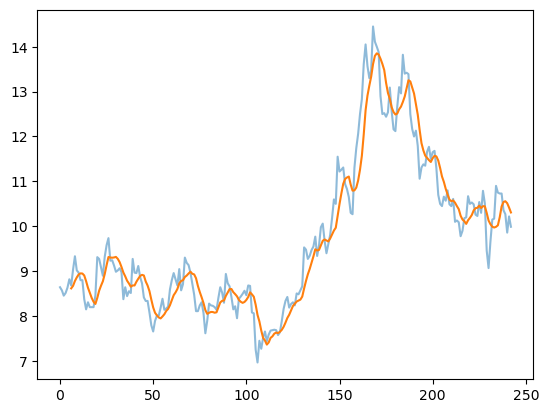

In [ ]:
%matplotlib inline

stock_index = '002057.SZ'
df = utilsJ.stock_ts(stock_index)

plt.plot(range(len(df)), df.close, alpha = 0.5)
plt.plot(range(len(df)), df.close.rolling(7).mean())

对橘线进行求一阶导，可得以下趋势，其中每一次穿越 $y=0$ 表示波浪改变方向。

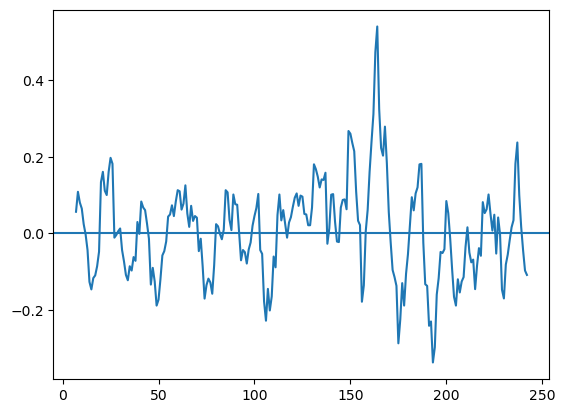

In [ ]:
%matplotlib inline
plt.plot(range(1, len(df)), np.diff(df.close.rolling(7).mean()))
plt.axhline(0)

### 策略细节

参数：
1. 日线平均周期，默认为5。
2. 信号栈长短，默认为3.

步骤：
1. 计算当日均线与昨日均线之差。如差值大于0，则向信号栈末尾添加‘上升’信号(1)；若差值小于等于0，则向信号栈末尾添加'下降'信号(-1)。
2. 如果信号栈呈现特定的排列，则释放买入/卖出信号。
3. 每次买入100股，每次全部卖出。

例如：
信号栈长短为3。

连续两天下跌，今日上涨，则信号栈为[-1, -1, 1]，可能是从调整浪变为上升浪，则进行买入；

连续两天上涨，今日下跌，则信号栈为[1, 1, -1]，可能是从上升浪变为调整浪，则进行卖出。

In [3]:
class Wave(bt.Strategy):
    
    params = (
        ('printlog', False),
        ('smoothing_period', 5),
        ('stack_len', 3),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Initialization
        self.order = None
        self.buyprice = None
        self.sellprice = None

        # Alias
        self.dataclose = self.data.close

        # Indicators
        ## SMA
        self.sma = btind.SMA(self.dataclose, period=self.p.smoothing_period)
        
        ## Singal stack
        self.stack = [0] * self.p.stack_len


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Cash: %i, Value: %i' %
                         (order.executed.price, order.executed.size,
                          self.broker.get_cash(), self.broker.get_value()))
                self.buyprice = order.executed.price

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Cash: %i, Value: %i' %
                        (order.executed.price, -order.executed.size,
                         self.broker.get_cash(), self.broker.get_value()))
                self.sellprice = order.executed.price

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next(self):

        if self.order:
            return
        
        for i in range(1, self.p.stack_len+1):
            self.stack[-i] = 1 if self.sma[-i+1] - self.sma[-i] > 0 else -1
        
        # Signals
        buy_s = self.stack[-1] == 1 and \
                sum(self.stack) in [-1*(self.p.stack_len-2), -1*(self.p.stack_len-3)]
        sell_s = self.stack[-1] == -1 and \
                 sum(self.stack) in [1*(self.p.stack_len-2), 1*(self.p.stack_len-3)]
        
        if buy_s:
            if self.buyprice is None:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                         (self.dataclose[0], 100, self.getposition(self.data).size))
                self.order = self.buy(size=100)            
            elif self.dataclose > self.buyprice:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                         (self.dataclose[0], 100, self.getposition(self.data).size))
                self.order = self.buy(size=100)
        elif sell_s:
                if self.getposition(self.data).size > 0:
                    self.log('SELL CREATE (Close), Price: %.2f, Lots: %i' % 
                             (self.dataclose[0], self.getposition(self.data).size))
                    self.order = self.close()

## 回测

### 个股回测

In [ ]:
stock_index = '002057.SZ'
startdate = dt.datetime.now() - dt.timedelta(days=365)
enddate = dt.datetime.now()

if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Wave,printlog=True, smoothing_period=7) 

    # Create stock Data Feed
    df = utilsJ.get_stock(stock_index, startdate, enddate)
    data = btfeed.PandasData(dataname=df,fromdate=startdate,todate=enddate)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)
    
    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(2000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

    cerebro.plot(iplot=False)

## 全市场回测

In [ ]:
profit_list = []
startdate = dt.date(2019,12,31)
enddate = dt.date(2021,12,31)

if __name__ == '__main__':

    stock_list = utilsJ.get_stock_list()
    for stk in stock_list:
        # Create a cerebro entity
        cerebro = bt.Cerebro()

        # Add a strategy
        strats = cerebro.addstrategy(Wave,printlog=False, smoothing_period=7) 

        # Create stock Data Feed
        df = utilsJ.get_stock(stk, startdate, enddate)
        data = btfeed.PandasData(dataname=df,fromdate=startdate,todate=enddate)

        # Add the index Data Feed to Cerebo
        cerebro.adddata(data)
        
        # Set cash inside the strategy
        cerebro.broker = bt.brokers.BackBroker(coc=True)
        cerebro.broker.setcash(10000)

        # Set commission
        #cerebro.broker.setcommission()

        # Print out the starting conditions
        start_value = cerebro.broker.getvalue()
        #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Run over everything
        cerebro.run()

        # Print out the final result
        final_value = cerebro.broker.getvalue()
        #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        net_profit = (final_value - start_value) / start_value * 100
        profit_list.append((stk, net_profit))
        time.sleep(0.5)
    sorted(profit_list, key=lambda x: x[1], reverse=True)